In [1]:
#!python -m pip install networkx
#!python -m pip install matplotlib==2.2.3
#!python -m pip install ipywidgets
#!python -m pip install graphviz

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random
#from ipywidgets import GridspecLayout, Button, Layout
import math
import sys
from graphviz import Digraph




Bad key "text.kerning_factor" on line 4 in
/home/fran/.local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
import copy
class Slot():

    def __init__(self, word, is_core, page_destination):

        # word = str que l'on souhaite traiter et placer sur la grille
        # is Core = Booléen un indiquant si le mot traité fait parti du vocabulaire core ou non
        self.__word = copy.copy(word)
        self.__is_core = copy.copy(is_core)
        self.__page_destination = copy.copy(page_destination)

    # Accesseur
    def get_word(self):

        return self.__word

    # Accesseur
    def get_is_core(self):

        return self.__is_core

    def get_page_destination(self):

        return self.__page_destination

    def set_word(self, word):

        self.__word = word

    def set_page_destination(self, page):

        self.__page_destination = page

    def __str__(self):

        dest = self.__page_destination
        if dest:
            dest = self.__page_destination.get_name()
        # return '('+str(self.__word) + ';' + str(self.__is_core) + ';' + str(dest) + ')'
        return f'{self.__word}({dest})'



In [4]:
class Page():

    #Constructor
    def __init__(self, name, row_size, col_size):

        self.__name = name
        self.__row_size = row_size
        self.__col_size = col_size
        self.__full = False
        self.__slots = []
        self.__fill()
        self.__last_R = 0
        self.__last_C = 0

    #Initialise chacun des slots à None
    def __fill(self):

      self.__slots = []
      for i in range(0, self.__row_size) :
        self.__slots.append([None])
        for j in range(0, self.__col_size) :
          self.__slots[i].append(None)

    # Ajoute le Slot slot en position num_row, num_col et renvoie l'ancienne valeur
    def set_slot(self, slot, num_row, num_col):

      if (num_row >= self.__row_size) or (num_col >= self.__col_size):
        raise Exception('Error: slot row or col out of bounds') 

      old_value = self.__slots[num_row][num_col]
      self.__slots[num_row][num_col]=slot
      return old_value

    def set_name(self, name):
      self.__name = name
      return name

    # Accessors
    def get_name(self):

      return self.__name

    def get_row_size(self):

      return self.__row_size

    def get_col_size(self):

      return self.__col_size

    def get_slot(self, num_row, num_col):

      return self.__slots[num_row][num_col]

    def get_slot_by_name(self, name):

      for row in range(0, self.__row_size):
        for col in range (0, self.__col_size):
          slot = self.__slots[row][col]
          if slot:          
            if slot.get_word() == name:
              return slot
          
      print(f'*** slot {name} not found in page {self.__name} ***')
      return None
    
    def get_pictograms(self):

      current_page_name = self.get_name()
      attributes = {}
      for row in range(0, self.__row_size):
        for col in range (0, self.__col_size):
          slot = self.__slots[row][col]
          if slot:
            word = slot.get_word()
            dest = slot.get_page_destination()
            if dest:
              dest_page_name = dest.get_name()
            else:
              dest_page_name = None
              
            attributes[f'{word}@{current_page_name}'] = [word, row, col, current_page_name, dest_page_name]  

      return attributes
      
    # def get_slot_by_destination(self, dest):
      
    #   for row in range(0, self.__row_size):
    #     for col in range (0, self.__col_size):
    #       slot = self.__slots[row][col]
    #       if slot:          
    #         if slot.get_page_destination == dest:
    #           return slot
          
    #   print(f'*** destination {dest} not found in any slot ofpage {self.__name} ***')
    #   return None

    def get_slot_list(self):

      return self.__slots

    #Return true if the slot at position (num_row, num_col) is free, false otherwise
    def is_free(self, num_row, num_col):

      return self.__slots[num_row][num_col] == None

    #Return true if table is full, false otherwise
    def is_full(self):

      if (self.__full):
        return True
      for row in range(0, self.__row_size):
        for col in range (0, self.__col_size):
          if self.__slots[row][col] == None:
            return False
      self.__full = True
      return True

    def add_word(self, word, core=False, dest=None) :

      if(self.__last_C == self.__col_size) : 
        self.__last_C = 0
        self.__last_R += 1
      if(self.__last_R == self.__row_size) :
        self.__full = True
        print("Failed to add word <", word, ">. The table is full.")
        return None

      if(self.__slots[self.__last_R][self.__last_C] == None) :

        s = Slot(word, core, dest)
        self.__slots[self.__last_R][self.__last_C] = s
        self.__last_R
        self.__last_C += 1
        return word
      
      self.__last_R
      self.__last_C += 1
      return self.add_word(word, dest=dest)

    # Méthode d'affichage (à revoir ? Efficacité chaînes de caractères)
    def __str__(self):

      s = "Page: " + self.__name + "\n("
      for i in range(0, self.__row_size) : 
        for j in range(0, self.__col_size) :
          s+=str(self.__slots[i][j])
          s+=", "
        s+='\n'
      return s+')'

    # fonction auxiliaire pour l'affichage
    def create_expanded_button(self, description, button_style):

      return Button(description=description, button_style=button_style,
                  layout=Layout(height='auto', width='auto'))
       
    # Affichage alternative (couteaux, debug)
    def show(self):

      grid = GridspecLayout(self.__row_size, self.__col_size, width='50%')

      for i in range(self.__row_size):
        for j in range(self.__col_size):
          # grid[i, j] = self.create_expanded_button('Button {} - {}'.format(i, j), 'success')
          if self.__slots[i][j]:
            content = str(self.__slots[i][j])
          else:
            content = ''
          grid[i, j] = self.create_expanded_button(content, 'success')            


      return grid



In [84]:
class Grid():

  #Constructor
  def __init__(self, input_file):

    self.__row_size = None
    self.__col_size = None
    self.__core_voc = {}
    self.__pages = {}
    self.__pageCounter = 0     
    self.__fusion_id = 0
    self.__create_grid(input_file)

  #ToDo
  def add_word(word):

    return

  def get_root_page(self):

    return self.__pages.get('accueil')

  # def __get_last_page(self):

  #   return self.__pages[-1]
  
  def get_nb_pages(self):

    return self.__pageCounter
  
  def get_page_names(self):

    return self.__pages.keys()

  def get_page(self, name):

    return self.__pages.get(name) 

  def get_page_dict(self):

    return self.__pages

  def get_core_voc(self):

    return self.__core_voc

  def get_row_size(self):

    return self.__row_size

  def get_col_size(self):

    return self.__col_size

  # We assume that the word has not been already added
  def add_word(self, word, dest=None):

    # if self.__pages[-1].is_full() :

    #   self.__add_page2()

    # self.__pages[-1].add_word(word, dest=dest)

    return
  
  def add_word_in_root(self, word, dest=None):

    accueil_page = self.__pages.get('accueil')
    if accueil_page.is_full() :

      print('accueil complète, désolé')
      return

    accueil_page.add_word(word, dest=dest)

    return

  # def __add_page(self):

    # accueil_page = self.__add_page.get('accueil')
    # self.__add_core_voc()    

  def add_new_page(self, name):

    return self.__add_page(name)

  def __add_page(self, name_page):

    page = Page(name_page, self.__row_size, self.__col_size)    
    self.__pages[name_page] = page
    self.__pageCounter += 1 

    return page

  def update_leaf_picto(self, extra_page):
    '''Recherche le premier pictogramme qui n'a pas de page de destination et mettre en place extra_page
        comme destination.
        Renvoie la page contenant le picto trouvé'''

    core_voc_dict = self.get_core_voc()
    for page in self.get_page_dict().values():
      for row in range(1, page.get_row_size()):
        for col in range(1, page.get_col_size()):
          slot = page.get_slot(row, col)
          if not slot.get_page_destination():
            slot.set_page_destination(extra_page)
            core_voc_dict.get(f'{slot.get_word()}@{page.get_name()}')[4] = extra_page.get_name()
            
            return page


  def __create_grid(self, input_file):
    ''' Création d'une grille à partir d'un fichier texte ou un dict d'attributes '''

    #références pour le calcul de row_size, col_size et destination
    row_ref = 0
    col_ref = 0
    first_page = None
    last_id = None

    # l'entrée est un dictionaire de pictogrammes
    if isinstance(input_file, dict):
      print("Grille créée à partir d'un dictionaire de pictogrammes")
      print()

      self.__core_voc = dict(input_file)

      # obtenir row_size et col_size auprès de input_file
      
      for picto in self.__core_voc.values():
        row = int(picto[1])
        column = int(picto[2])
        page = picto[3]

        if not first_page:
              first_page = page

        # determiner la taille de la grille
        if page == first_page:
          if row > row_ref:
            row_ref = row
          if column > col_ref:
            col_ref = column
        else:
          break
      
      self.__row_size = row_ref + 1
      self.__col_size = col_ref + 1

    # l'entrée est un fichier .csv en format Augcom
    elif input_file.endswith('.csv'):
      print("Grille créée à partir du fichier " + input_file)
      print()

      # Fichier brut à traiter
      with open(input_file, "r") as rawFile:

        # Processing the source file
        for lines in rawFile:
          lines = lines.lower()
          sentence = lines.strip()
          col = sentence.split("\t")		

          # We manage the problem of semi-empty lines created by links between directories
          if len(col) > 4:
            
            word = col[0]
            row = int(col[1])
            column = int(col[2])
            page = col[3]			
            id = col[4]

            # save word, coordinates, current page and destination of each pictogram
            self.__core_voc[id] = [word, row, column, page, None]
            
            if not first_page:
              first_page = page

            # determiner la taille de la grille
            if page == first_page:
              if row > row_ref:
                row_ref = row
              if column > col_ref:
                col_ref = column
            
            last_id = id

          # We recover the links between the directories
          elif len(col) > 1:
            pointed_link = col[1]            			
            self.__core_voc.get(last_id)[4] = pointed_link
      
      self.__row_size = row_ref + 1
      self.__col_size = col_ref + 1

    else:
      raise Exception('Incompatible input. Only dict (pictos attributes) or .csv files (augcom format) are accepted')

    self.__add_core_voc()


  def __add_core_voc(self):

    for picto in self.__core_voc.values():
      word = picto[0]
      row = picto[1]
      col = picto[2]
      page_name = picto[3]
      dest_name = picto[4]

      if page_name in self.__pages:
        page = self.__pages.get(page_name)
      else:		  
        page = self.__add_page(page_name)
          
      if dest_name:
        if dest_name in self.__pages:
          destination = self.__pages.get(dest_name)
        else:			
          destination = self.__add_page(dest_name)          
      else:
        destination = None

      slot = Slot(word, True, destination)      
      page.set_slot(slot, row, col)

  def to_graph(self):

    nodes = set([])
    edges = set([])
    for key,page in self.__pages.items():
      nodes.add(key)
      slots = page.get_slot_list()
      for items in slots:
        for slot in items:
          if slot != None:
            dest = slot.get_page_destination()
            if dest != None:
              dest = dest.get_name()
              edges.add((key, dest))
    
    G=nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    nx.draw(G,with_labels=True)
    # plt.savefig("grid_graph.png") # save as png
    plt.show() # display

    return G

  def cross_pages(self, page1, page2, parent=None):
    ''' Croise page1 avec page2 et toutes les sous-pages analogues reliées aux page1 et page2.
        'parent' identifie une page qui fait un appel récursive.
    '''

    # nous supposons que les deux pages ont la même taille
    if page1:
      row_size = page1.get_row_size()
      col_size = page1.get_col_size()
    elif page2:
      row_size = page2.get_row_size()
      col_size = page2.get_col_size()
    
    new_page_name_suffix = random.randint(0,1000)

    # liste de tous les attributs des pictogrammes de la page résultante
    attributes = {}
    unallocated_pictos = {}

    # cas 1: Aucune page n'existe
    if (not page1) and (not page2):
      # print('Rien a croiser, fin de la fonction')
      
      return {}, None, {}
    
    # cas 2: seul page1 existe
    if page1 and (not page2):
      result_page = copy.deepcopy(page1)
      picto_dict = result_page.get_pictograms()

      # chercher et m-à-j le picto de retour.
      for picto in picto_dict.values():
        if (picto[0] == 'retour') and (picto[1] == row_size - 1) and (picto[2] == col_size - 1):
          if parent:
            picto_dict[f'retour@{result_page.get_name()}'][4] = parent.get_name()
            print('Pictogram de retour mise à jour')
      attributes.update(picto_dict)
      
      return attributes, result_page, {}
    
    # cas 3: seul page2 existe
    if page2 and (not page1):        
      result_page = copy.deepcopy(page2) 
      picto_dict = result_page.get_pictograms()

      # chercher et m-à-j le picto de retour.
      for picto in picto_dict.values():
        if (picto[0] == 'retour') and (picto[1] == row_size - 1) and (picto[2] == col_size - 1):
          if parent:
            picto_dict[f'retour@{result_page.get_name()}'][4] = parent.get_name()
            print('Pictogram de retour mise à jour')
      attributes.update(picto_dict)
      
      return attributes, result_page, {}

    # cas 4: les deux pages existent
    if page1 and page2:

      # décider du nom à retenir
      if random.randint(0,1):
        new_page_name = page1.get_name()
      else:
        new_page_name = page2.get_name()

      #ajouter suffixe au nom de la page pour la differencier des pages de base
      # new_page_name += f'_{new_page_name_suffix}'

      #page résultante
      result_page = Page(new_page_name, row_size, col_size)

      #sélectionner les pictos qui vont populer la page résultante
      for row in range(row_size):
        for col in range(col_size):
          slot_page1 = copy.deepcopy(page1.get_slot(row, col))
          slot_page2 = copy.deepcopy(page2.get_slot(row, col))
          random_selector = random.randint(0,1)

          if (slot_page1) and (slot_page2):
            dest_1 = slot_page1.get_page_destination()
            dest_2 = slot_page2.get_page_destination()

            if random_selector:
              selected_slot = slot_page1
              not_selected_slot = slot_page2
              page_name = page1.get_name()
              page_name_not_selected = page2.get_name()
              
            else:
              selected_slot = slot_page2
              not_selected_slot = slot_page1
              page_name = page2.get_name()
              page_name_not_selected = page1.get_name()

            #déterminer (recursivement) la destination du slot selectionné
            if (selected_slot.get_word() != 'retour'):              
              attribs, selected_dest_page, unalloc = self.cross_pages(dest_1, dest_2, result_page)
			      # picto de retour trouvé
            elif (row == row_size - 1) and (col == col_size - 1):
              attribs, selected_dest_page, unalloc = {}, parent, {}

            #garder les pictos non affectés --------------------------------------
            word_not_selected = not_selected_slot.get_word()
            if word_not_selected != 'retour':
              id_not_selected = f'{word_not_selected}@{page_name_not_selected}'

              #si deux pictos non affectés ont le même id, modifier légerement l'id de l'un des deux
              if id_not_selected in unallocated_pictos:
                # '**' à la fin d'une id indiquent l'existence de 2 pictos differents avec la même mot et même nom de page 
                id_not_selected = f'{word_not_selected}@{page_name_not_selected}**'            
                        
              unallocated_pictos[id_not_selected] = [word_not_selected]

          elif slot_page1:
            selected_slot = slot_page1
            page_name = page1.get_name()

            if selected_slot.get_word() != 'retour':
              dest_1 = slot_page1.get_page_destination()
              attribs, selected_dest_page, unalloc = self.cross_pages(dest_1, None, result_page)            
            else:
              if parent:
                attribs, selected_dest_page, unalloc = {}, parent, {}              

          elif slot_page2:
            selected_slot = slot_page2
            page_name = page2.get_name()

            if selected_slot.get_word() != 'retour':
              dest_2 = slot_page2.get_page_destination()
              attribs, selected_dest_page, unalloc = self.cross_pages(dest_2, None, result_page)            
            else:
              if parent:
                attribs, selected_dest_page, unalloc = {}, parent, {}
            
          # aucun des pictos n'existe
          else: 
            selected_slot = None            

          #m-à-j des attributes des pictogrammes de la page résultante
          if selected_slot:
            selected_slot.set_page_destination(selected_dest_page)
            word = selected_slot.get_word()

            #ajouter les pictos des pages de destination
            attributes.update(attribs)

            #m-à-j le dict de pictos non affectés avec ceux des appels récursives
            unallocated_pictos.update(unalloc)

            id = f'{word}@{page_name}'

            if selected_dest_page:                
                dest_page_name = selected_dest_page.get_name()
            else:
              dest_page_name = None
            #si deux pictos ont le même id, modifier légerement l'id de l'un d'eux
            if id in attributes:
              id = f'{word}@{page_name}**'
            
            attributes[id] = [word, row, col, new_page_name, dest_page_name]

          # mettre en place le picto selectionné dans la page résultante 
          result_page.set_slot(selected_slot, row, col)     
    
    return attributes, result_page, unallocated_pictos

  ''' '''  
  def fusion_with(self, grid):
    
    current_accueil = next(iter(self.get_page_dict().values())) 
    foreing_accueil = next(iter(grid.get_page_dict().values())) 

    attributes_dict, result_page, unalloc_dict = self.cross_pages(current_accueil, foreing_accueil)
    

    new_grid = Grid(attributes_dict)

    print(new_grid.get_core_voc())
    print(unalloc_dict)

    row_size = result_page.get_row_size()
    col_size = result_page.get_col_size()

    # remplir slots vides avec les pictos non affectées **********************
    for page in new_grid.get_page_dict().values():
      for row in range(1, row_size):
        for col in range(1, col_size):
          slot = page.get_slot(row, col)
          if not slot:
            try:
              id_next_unalloc_picto = next(iter(unalloc_dict))
              #vérifier si l'id du picto non alloué existe dans le dict d'attributes de la grille 
              if id_next_unalloc_picto in new_grid.get_core_voc():
                new_id = f'{id_next_unalloc_picto}**'
                unalloc_dict[new_id] = unalloc_dict.pop(id_next_unalloc_picto)
                id_next_unalloc_picto = new_id
              unalloc_picto = unalloc_dict.pop(id_next_unalloc_picto)
              word = unalloc_picto[0]
              slot = Slot(word, False, None)
              page.set_slot(slot, row, col)
              #m-à-j du dict d'attriburtes de la nouvelle grille
              new_grid.get_core_voc()[id_next_unalloc_picto] = [word, row, col, page.get_name(), None]              
            except:
              print('** unalloc_dict est vide, fusion complète **')
              return new_grid
    print(new_grid.get_core_voc())
    # gérer le cas où il y a plus de pictos non alloués que de stocks vides.
    while len(unalloc_dict):
      
      # créer et ajouter une page extra pour les allouer
      extra_page_name = f'extra_{random.randint(0,1000)}'    
      extra_page = new_grid.add_new_page(extra_page_name)

      # choisir le picto connecté à la page extra. On parcours les pages en partant de l'accueil.
      origin_page = new_grid.update_leaf_picto(extra_page)    

      # mettre en place le picto de retour
      if origin_page:
        picto_retour = Slot('retour', False, origin_page)
        extra_page.set_slot(picto_retour, row_size - 1, col_size - 1)
        new_grid.get_core_voc()[f'retour@{extra_page_name}'] = ['retour', row_size - 1, col_size - 1, extra_page_name, origin_page.get_name()]
      
      # remplir slots vides de la page extra avec des pictos non affectées
      for row in range(1, row_size):
          for col in range(1, col_size):
            slot = extra_page.get_slot(row, col)
            if not slot:
              try:
                id_next_unalloc_picto = next(iter(unalloc_dict))
                unalloc_picto = unalloc_dict.pop(id_next_unalloc_picto)
                word = unalloc_picto[0]
                slot = Slot(word, False, None)
                extra_page.set_slot(slot, row, col)
                #m-à-j du dict d'attriburtes de la nouvelle grille
                new_grid.get_core_voc()[id_next_unalloc_picto] = [word, row, col, extra_page.get_name(), None]              
              except:
                print('** unalloc_dict est vide, fusion complète **')                
                return new_grid

    
    return new_grid

  def to_text(self, output_name='grid_text.csv'):

    print("output file is " + output_name)
    print()
    sorted_attrib_dict = {}

    # trier le dict d'attributes par nom de page
    for page_name in self.get_page_dict():     
      for picto_id, attributes in self.get_core_voc().items():
        if attributes[3] == page_name:
          sorted_attrib_dict[picto_id] = self.get_core_voc().get(picto_id)       

    # Fichier résultant
    with open(output_name, "w") as text_file:
      for picto_id, attributes in sorted_attrib_dict.items():
        print(f'{attributes[0].upper()}\t{attributes[1]}\t{attributes[2]}\t{attributes[3]}\t{picto_id}', file=text_file) 
        if attributes[4]:
          print(f'\t\t\t{picto_id}\t{attributes[4]}', file=text_file)

  # Méthode d'affichage 1
  def __str__(self):

    s = 'grid : {\n'
    for page in self.__pages.values():
      s+= str(page) + '\n'
    s += '}\n'
    return s

    # s = 'grid : {\n'
    # for i in range(0, len(self.__pages)):
    #   s+= str(self.__pages[i]) + '\n'
    # s += '}\n'
    # return s

  # Méthode d'affichage 2
  # def display(self):
  #   g = []
  #   for i in range(len(self.__pages)):
  #     g.append(self.__pages[i].show())
    
  #   return g

  def display(self):
    ''' Génére un graph detaillé de l'estructure de la grille. Il utilise Graphviz et le language DOT'''

    graph = Digraph(comment='Test', node_attr={'shape': 'record'}) #, 'fixedsize': 'true', 'width':'4', 'height':'2'})
    row_size = self.get_row_size()
    col_size = self.get_col_size()
    slot_index = 0

    for page_name,page in self.get_page_dict().items():
      
      attribute_string = '{ '
      separator_1 = ''
      for row in range(0, row_size):
        separator_2 = ''
        attribute_string += f'{separator_1}' + ' { '
        for col in range(0, col_size):
          slot_index  = row * col_size + col
          slot = page.get_slot(row, col)

          if slot:
            word = slot.get_word()
            dest = slot.get_page_destination()
            #ajouter lien entre picto directoire et la page correspondante 
            if dest:
              graph.edge(f'{page_name}:{slot_index}', f'{dest.get_name()}')
          else:
            word = ''

          attribute_string += f'{separator_2}<{slot_index}>{word} '
          separator_2 = '|'

        separator_1 = '|'
        attribute_string += '} '
      attribute_string += ' }'

      #créer noeud 
      graph.node(f'{page_name}', f'{attribute_string}')
    #  print(attribute_string)
    #print(graph.source)

    return graph



# TESTING

# GraphViz

## Test fusion - grids with multiple different levels

In [85]:
grid1 = Grid('testing/grid_1_3p_raw.csv')

Grille créée à partir du fichier testing/grid_1_3p_raw.csv



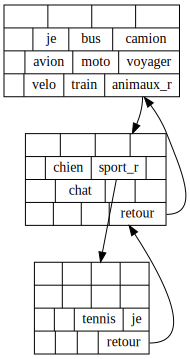

In [38]:
grid1.display()

In [86]:
grid2 = Grid('testing/grid_2_2p_raw.csv')
# grid2.get_page_dict().get('accueil').show()

Grille créée à partir du fichier testing/grid_2_2p_raw.csv



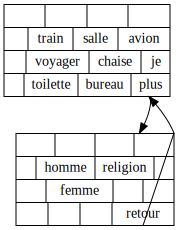

In [61]:
grid2.display()

In [87]:
grid3 = grid1.fusion_with(grid2)
# first_page = next(iter(grid3.get_page_dict().values())) 

Pictogram de retour mise à jour
Grille créée à partir d'un dictionaire de pictogrammes

{'train@accueil': ['train', 1, 1, 'accueil', None], 'bus@accueil': ['bus', 1, 2, 'accueil', None], 'avion@accueil': ['avion', 1, 3, 'accueil', None], 'voyager@accueil': ['voyager', 2, 1, 'accueil', None], 'moto@accueil': ['moto', 2, 2, 'accueil', None], 'je@accueil': ['je', 2, 3, 'accueil', None], 'velo@accueil': ['velo', 3, 1, 'accueil', None], 'bureau@accueil': ['bureau', 3, 2, 'accueil', None], 'chien@animaux': ['chien', 1, 1, 'personnes', None], 'tennis@sport': ['tennis', 2, 2, 'sport', None], 'je@sport': ['je', 2, 3, 'sport', None], 'retour@sport': ['retour', 3, 3, 'sport', 'personnes'], 'sport_r@animaux': ['sport_r', 1, 2, 'personnes', 'sport'], 'chat@animaux': ['chat', 2, 1, 'personnes', None], 'retour@animaux': ['retour', 3, 3, 'personnes', 'accueil'], 'plus@accueil': ['plus', 3, 3, 'accueil', 'personnes']}
{'je@accueil': ['je'], 'salle@accueil': ['salle'], 'camion@accueil': ['camion'], 'avi

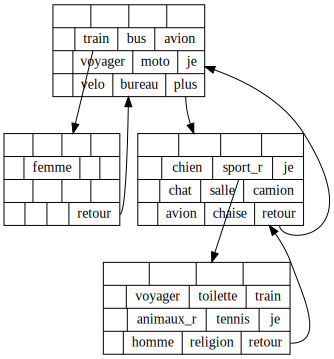

In [88]:
grid3.display()

output file is testing/test3.csv

Grille créée à partir du fichier testing/test3.csv



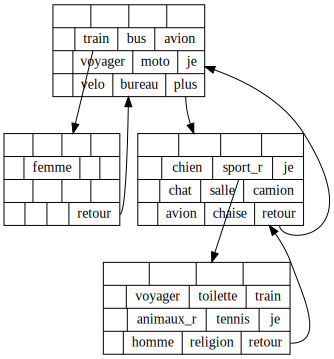

In [89]:
grid3.to_text('testing/test3.csv')
grid4 = Grid('testing/test3.csv')
grid4.display()

In [90]:
len(grid4.get_core_voc())

29

In [42]:
import numpy as np
len(grid4.get_core_voc())

28

In [38]:
print(grid3.get_page_names())
print(grid4.get_page_names())

dict_keys(['accueil', 'animaux', 'sport', 'extra_838'])
dict_keys(['sport', 'extra_838', 'accueil', 'animaux'])


In [31]:
print(grid3)
print(grid4)

grid : {
Page: accueil
(None, None, None, None, 
None, train(extra_487), bus(None), avion(None), 
None, voyager(None), moto(None), je(None), 
None, toilette(None), bureau(None), plus(animaux), 
)
Page: animaux
(None, None, None, None, 
None, homme(None), religion(sport), je(None), 
None, chat(None), salle(None), camion(None), 
None, voyager(None), avion(None), retour(accueil), 
)
Page: sport
(None, None, None, None, 
None, chaise(None), voyager(None), velo(None), 
None, train(None), tennis(None), je(None), 
None, animaux_r(None), chien(None), retour(animaux), 
)
Page: extra_487
(None, None, None, None, 
None, sport_r(None), femme(None), None, 
None, None, None, None, 
None, None, None, retour(accueil), 
)
}

grid : {
Page: sport
(None, None, None, None, 
None, chaise(None), voyager(None), velo(None), 
None, train(extra_487), tennis(None), je(None), 
None, animaux_r(None), chien(None), retour(animaux), 
)
Page: extra_487
(None, None, None, None, 
None, sport_r(None), femme(None), None, 

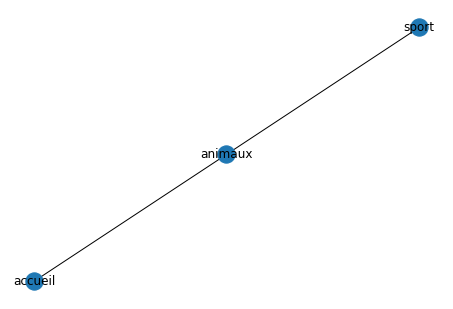

In [12]:
grid1.to_graph()

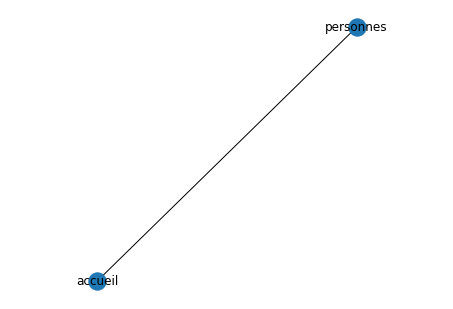

In [13]:
grid2.to_graph()

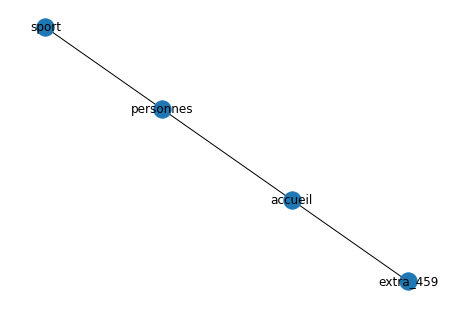

In [14]:
grid3.to_graph()

In [16]:
grid3.to_text('testing/grid_3_fusion_raw.csv')

output file is testing/grid_3_fusion_raw.csv



## Test fusion 2 pages -  proloquo simple


In [ ]:
grid_1 = create_grid('proloquoSimple1.csv')
grid_2 = create_grid('proloquoSimple2.csv')
print(grid_1)
print(grid_2)

In [136]:
grid_1.get_root_page().show()

GridspecLayout(children=(Button(button_style='success', layout=Layout(grid_area='widget001', height='auto', wi…

In [137]:
grid_2.get_root_page().show()

GridspecLayout(children=(Button(button_style='success', layout=Layout(grid_area='widget001', height='auto', wi…

In [129]:
fusion_grid.get_page('accueil').show()

GridspecLayout(children=(Button(button_style='success', layout=Layout(grid_area='widget001', height='auto', wi…

In [128]:
fusion_grid = grid_1.fusion_with(grid_2)
print(fusion)

grid : {
Page: accueil397
(None, None, None, None, None, None, None, None, None, 
None, nourriture_r, être, vouloir, aimer, indices_r, quoi, où_r, lequel_r, 
None, conjonctions_r, arrêter, école_r, avoir, choses de la maison_r, pour, pas, c'est fini, 
None, ça, regarder, aider, actions_r, avec, à, bien, aide_r, 
None, personnes_r, choses_r, lieux_r, décrire_r, petits mots_r, chat_r, activités_r, plus, 
)
}



In [ ]:
g = create_grid("proloquoTest.csv")
print(g)

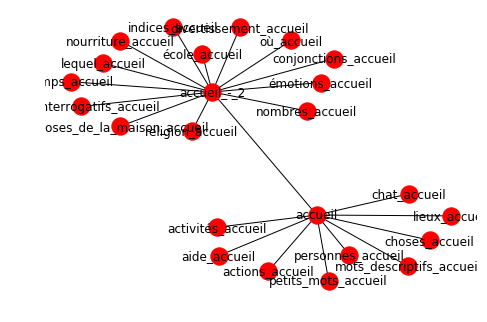

In [47]:
g.to_graph()

In [55]:
g.get_page('accueil_-_2').show()

GridspecLayout(children=(Button(button_style='success', description='None', layout=Layout(grid_area='widget001…

## test 1: fusion simple 

In [15]:
c_v = [["je", 0, 1], ["vouloir", 0, 0], ["quoi", 1, 1], ["pourquoi", 1, 0], ["h", 0, 2]]
g1 = Grid(3,3, c_v)
np1 = g1.add_new_page('g1_p1')
# np2 = g1.add_new_page('g1_p2')
g1.add_word_in_root('to_g1_p1', dest=np1)
# np.add_word('HI', False, np2)
np1.add_word('retour@accueil', False, g1.get_page('accueil'))

g2 = Grid(3,3, [])

np2 = g2.add_new_page('g2_p1')
np3 = g2.add_new_page('g2_p2')
np4 = g2.add_new_page('g2_p3')
g2.add_word_in_root('to_g2_p1', dest=np2)
g2.add_word_in_root('to_g2_p2', dest=np3)
np3.add_word('hello', dest=np4)
np2.add_word('retour@accueil', False, g2.get_page('accueil'))
np3.add_word('retour@accueil', False, g2.get_page('accueil'))
# print(g1)
# print(g2)
# g1.to_graph()
# g2.to_graph()


AttributeError: 'function' object has no attribute 'get'

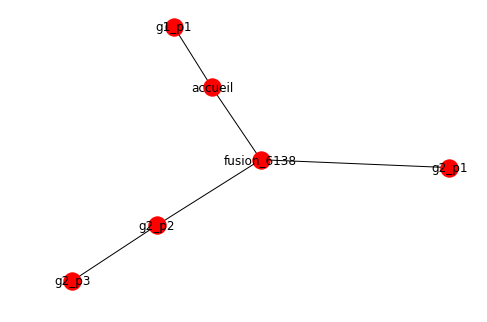

In [111]:
g3=g1.fusion_with(g2)
g3.to_graph()

In [109]:
print(g3)

grid : {
Page: accueil
((vouloir;True;None), (je;True;None), (h;True;None), 
(pourquoi;True;None), (quoi;True;None), (to_g1_p1;False;g1_p1), 
(to_fusion_4942;False;accueil), None, None, 
)
Page: g1_p1
((retour@accueil;False;accueil), None, None, 
None, None, None, 
None, None, None, 
)
Page: fusion_4942
((to_g2_p1;False;g2_p1), (to_g2_p2;False;g2_p2), (retour@accueil;False;accueil), 
None, None, None, 
None, None, None, 
)
Page: g2_p1
((retour@fusion_4942;False;fusion_4942), None, None, 
None, None, None, 
None, None, None, 
)
Page: g2_p2
((hello;False;g2_p3), (retour@fusion_4942;False;fusion_4942), None, 
None, None, None, 
None, None, None, 
)
Page: g2_p3
(None, None, None, 
None, None, None, 
None, None, None, 
)
}



## test 2: fusion simple 2

In [112]:
c_v = [["je", 0, 1], ["vouloir", 0, 0], ["quoi", 1, 1], ["pourquoi", 1, 0], ["h", 0, 2]]
g4 = Grid(3,3, c_v)
# print(g)
np5 = g4.add_new_page('g4_p1')
np6 = g4.add_new_page('g4_p2')
np7 = g4.add_new_page('g4_p3')
np8 = g4.add_new_page('g4_p4')
np5.add_word('hello', dest=np7)
np5.add_word('hello', dest=np8)
# np2 = g1.add_new_page('g1_p2')
g4.add_word_in_root('to_g4_p1', dest=np5)
g4.add_word_in_root('to_g4_p2', dest=np6)
# np.add_word('HI', False, np2)
np5.add_word('retour@accueil', False, g4.get_page('accueil'))
np6.add_word('retour@accueil', False, g4.get_page('accueil'))


g5 = Grid(3,3, [])
np9 = g5.add_new_page('g5_p1')
np10 = g5.add_new_page('g5_p2')
np11 = g5.add_new_page('g5_p3')
np12 = g5.add_new_page('g5_p4')
np13 = g5.add_new_page('g5_p5')
np14 = g5.add_new_page('g5_p6')
g5.add_word_in_root('to_g5_p1', dest=np9)
g5.add_word_in_root('to_g5_p2', dest=np10)
g5.add_word_in_root('to_g5_p3', dest=np11)
g5.add_word_in_root('to_g5_p4', dest=np12)
np12.add_word('hello', dest=np13)
np13.add_word('hello', dest=np14)
np9.add_word('retour@accueil', False, g5.get_page('accueil'))
np10.add_word('retour@accueil', False, g5.get_page('accueil'))
np11.add_word('retour@accueil', False, g5.get_page('accueil'))
np12.add_word('retour@accueil', False, g5.get_page('accueil'))

'retour@accueil'

In [ ]:
g6=g5.fusion_with(g4)
g6.to_graph()
print(g6)

## test3: fusion de fusions

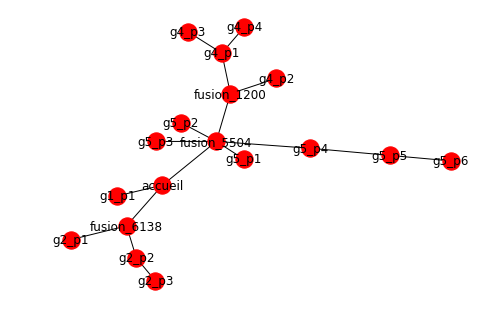

In [114]:
g7=g3.fusion_with(g6)
g7.to_graph()

## test 4: split

In [33]:
c_v_2 = [["je", 0, 1], ["vouloir", 0, 0], ["quoi", 1, 1], ["pourquoi", 1, 0]]
g8 = Grid(2,2, c_v_2)
np1 = g8.add_new_page('g8_p1')
np2 = g8.add_new_page('g8_p2')
root = g8.get_root_page()
root.get_slot(1,0).set_page_destination(np1)
root.get_slot(1,1).set_page_destination(np2)
# np.add_word('HI', False, np2)
np1.add_word('retour@accueil', False, root)
np2.add_word('retour@accueil', False, root)

'retour@accueil'

In [34]:
print(g8)

grid : {
Page: accueil
((vouloir;True;None), (je;True;None), 
(pourquoi;True;g8_p1), (quoi;True;g8_p2), 
)
Page: g8_p1
((retour@accueil;False;accueil), None, 
None, None, 
)
Page: g8_p2
((retour@accueil;False;accueil), None, 
None, None, 
)
}



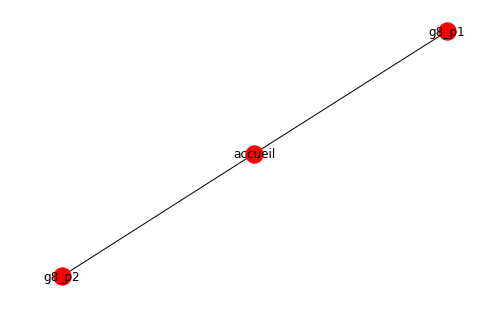

In [35]:
g8.to_graph()

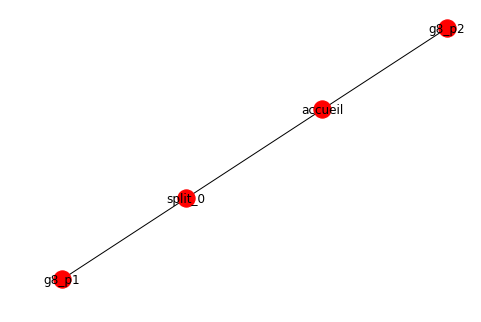

In [32]:
g8.split()
g8.to_graph()

## test 5: fusion (2ème cas)

In [ ]:
c_v_full = [["vouloir", 0, 0], ["je", 0, 1], ["pourquoi", 1, 0], ["quoi", 1, 1]]
c_v_free = [["je", 0, 1], ["pourquoi", 1, 0], ["quoi", 1, 1]]

g9 = Grid(2,2, c_v_full)
np1 = g9.add_new_page('g9_p1')
np2 = g9.add_new_page('g9_p2')
root = g9.get_root_page()
root.get_slot(1,0).set_page_destination(np1)
root.get_slot(1,1).set_page_destination(np2)
np1.add_word('retour@accueil', False, root)
np2.add_word('retour@accueil', False, root)

g10 = Grid(2,2, c_v_full)
np1 = g10.add_new_page('g10_p1')
np2 = g10.add_new_page('g10_p2')
root2 = g10.get_root_page()
root2.get_slot(1,0).set_page_destination(np1)
root2.get_slot(1,1).set_page_destination(np2)
np1.add_word('retour@accueil', False, root2)
np2.add_word('retour@accueil', False, root2)

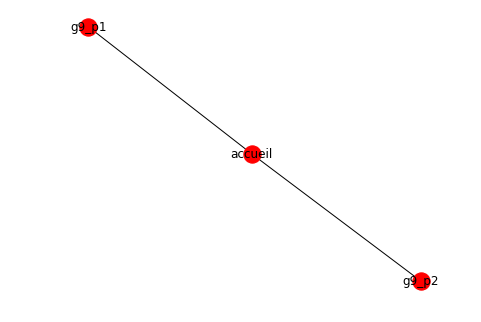

In [28]:
g9.to_graph()

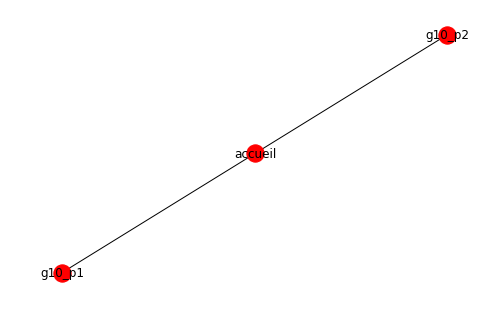

In [29]:
g10.to_graph()

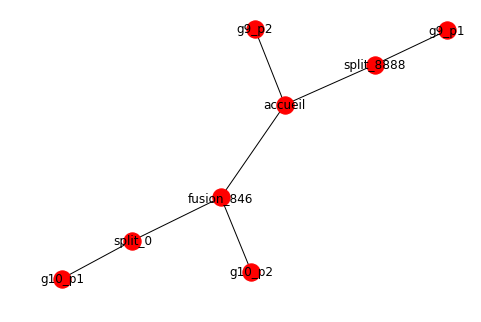

In [30]:
g11 = g9.fusion_with(g10)
g11.to_graph()

## Affichage alternative

In [36]:
root.show()

GridspecLayout(children=(Button(button_style='success', description='(vouloir;True;None)', layout=Layout(grid_…

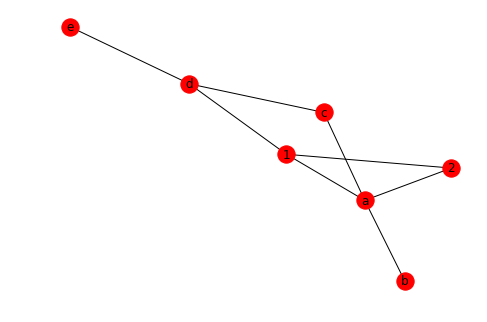

In [5]:
import networkx as nx
import matplotlib.pyplot as plt


G=nx.Graph()
G.add_node("a")
G.add_nodes_from(["b","c"])

G.add_edge(1,2)
edge = ("d", "e")
G.add_edge(*edge)
edge = ("a", "b")
G.add_edge(*edge)
# adding a list of edges:
G.add_edges_from([("a","c"),("c","d"), ("a",1), (1,"d"), ("a",2)])

nx.draw(G,with_labels=True)
# plt.savefig("simple_path.png") # save as png
plt.show() # display

In [9]:
from ipywidgets import GridspecLayout
def show():
    l = []  
    for a in range(2, 4):
      grid = GridspecLayout(a, a, width='50%')

      for i in range(a):
        for j in range(a):
          grid[i, j] = create_expanded_button('Button {} - {}'.format(i, j), 'success')
        #   grid[i, j] = create_expanded_button(str(self.__slots[i][j]), 'success')
      l.append(grid)
    return l

b = show()
b[0]


GridspecLayout(children=(Button(button_style='success', description='Button 0 - 0', layout=Layout(grid_area='w…

In [91]:
c_v = [["je", 0, 1], ["vouloir", 0, 0], ["quoi", 1, 1], ["pourquoi", 1, 0], ["h",0,2]]
g = Grid(2,3, c_v)
print(g)
g.add_new_page('page2')
print(g)



grid : {
Page: 0
((vouloir;True;None), (je;True;None), (h;True;None), 
(pourquoi;True;None), (quoi;True;None), None, 
)
}

grid : {
Page: 0
((vouloir;True;None), (je;True;None), (h;True;None), 
(pourquoi;True;None), (quoi;True;None), None, 
)
Page: page2
(None, None, None, 
None, None, None, 
)
}



In [7]:
from ipywidgets import Button, Layout, jslink, IntText, IntSlider

def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))

# top_left_button = create_expanded_button("Top left", 'info')
# top_right_button = create_expanded_button("Top right", 'success')
# bottom_left_button = create_expanded_button("Bottom left", 'danger')
# bottom_right_button = create_expanded_button("Bottom right", 'warning')

# top_left_text = IntText(description='Top left', layout=Layout(width='auto', height='auto'))
# top_right_text = IntText(description='Top right', layout=Layout(width='auto', height='auto'))
# bottom_left_slider = IntSlider(description='Bottom left', layout=Layout(width='auto', height='auto'))
# bottom_right_slider = IntSlider(description='Bottom right', layout=Layout(width='auto', height='auto'))

GridspecLayout(children=(Button(button_style='success', description='Button 0 - 0', layout=Layout(grid_area='w…

In [3]:
p = Page("animaux", 2, 2)
print(p)
print(p.is_full())
print(p.add_word("chat"))
print(p)
print(p.is_full())
print(p.add_word("chien"))
print(p)
print(p.is_full())
print(p.add_word("cheval"))
print(p)
print(p.is_full())
print(p.add_word("oiseau"))
print(p)
print(p.is_full())
print(p.add_word("dromadaire"))
print(p)
print(p.is_full())
print(p.add_word("chameau"))
print(p)
print(p.is_full())


Page: animaux
(None, None, 
None, None, 
)
False
chat
Page: animaux
((chat;False;None), None, 
None, None, 
)
False
chien
Page: animaux
((chat;False;None), (chien;False;None), 
None, None, 
)
False
cheval
Page: animaux
((chat;False;None), (chien;False;None), 
(cheval;False;None), None, 
)
False
oiseau
Page: animaux
((chat;False;None), (chien;False;None), 
(cheval;False;None), (oiseau;False;None), 
)
True
Failed to add word < dromadaire >. The table is full.
None
Page: animaux
((chat;False;None), (chien;False;None), 
(cheval;False;None), (oiseau;False;None), 
)
True
Failed to add word < chameau >. The table is full.
None
Page: animaux
((chat;False;None), (chien;False;None), 
(cheval;False;None), (oiseau;False;None), 
)
True


In [4]:
s = Slot("chien", True, "")
s2 = Slot("chat", False, "")
p = Page("animaux",3,4)
print(p.get_slot(1,2))
print(p.set_slot(s, 1,2))
print(p.get_slot(1,2))
print(p.set_slot(s, 1,2))
print(p.get_slot(1,2))
print(p.set_slot(s2, 1,2))
print(p.get_slot(1,2))
print(p)
print(p.get_name())
p.set_name("véhicules")
print(p)
print(p.get_name())
print(p.is_free(1,2))
print(p.is_free(2,2))
print(p.is_full())



None
None
(chien;True;)
(chien;True;)
(chien;True;)
(chien;True;)
(chat;False;)
Page: animaux
(None, None, None, None, 
None, None, (chat;False;), None, 
None, None, None, None, 
)
animaux
Page: véhicules
(None, None, None, None, 
None, None, (chat;False;), None, 
None, None, None, None, 
)
véhicules
False
True
False


In [7]:
# TESTING
# g = Grid(3,4, [["je", 0, 1], ["vouloir", 0, 0], ["quoi", 1, 1], ["pourquoi", 1, 0]])
# print(g)
# g.add_word("chien")
# print(g)
# g.add_word("chien")
# print(g)
# g.add_word("chien")
# print(g)
# g.get_number_pages()
